In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import os
from collections import Counter, defaultdict
from scipy import sparse
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
from itertools import groupby
from typing import Iterable, Any
import seaborn as sns
import igraph
import infomap
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics.cluster import contingency_matri
from scipy.special import comb


In [162]:
import warnings
warnings.filterwarnings('error')

In [3]:
import cProfile
%load_ext line_profiler

In [35]:
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize": (10, 6)})

In [4]:
class bidict(dict):
    def __init__(self, *args, **kwargs):
        
        super(bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value, []).append(key) 

    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value, []).append(key)        

    def __delitem__(self, key):
        self.inverse.setdefault(self[key], []).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(bidict, self).__delitem__(key)

In [5]:
def normalize(matrix: sparse.spmatrix) -> sparse.spmatrix:
    
    return matrix.T.multiply(1 / matrix.sum(axis=1)).T

In [6]:
def steady_state(transition: sparse.spmatrix, damping: float = .85, tol: float = 1e-7) -> np.ndarray:

    N = transition.shape[0]
    antidamp = (1 - damping) / N
    damped = normalize(transition) * damping
    projection = np.ones(N, dtype=np.int8)
    
    previous_stationary = (projection / N) @ damped# + antidamp
    stationary = previous_stationary @ damped# + antidamp

    while np.linalg.norm(stationary - previous_stationary) > tol:
        previous_stationary = stationary
        stationary = stationary @ damped + antidamp

    return stationary, damped

In [7]:
def joint_distribution(states, adjacency):

    return adjacency.T.multiply(states).T.tocsr()

In [8]:
def _cluster_edges(nodes, edges, state, antidamp, clusters):
        
        if clusters:
            
            return [(neighbor, antidamp * (len(clusters[neighbor]['nodes']) * state + clusters[neighbor]['state']) + sum([weight[1] for weight in weights]))
                        for neighbor, weights in groupby(
                            sorted([(nodes[edge], weight) 
                                    for _, edge, weight in edges], 
                                   key=lambda x: x[0]), 
                            key=lambda x: x[0])]
        
        return [(neighbor, sum([weight[1] for weight in weights]))
                            for neighbor, weights in groupby(
                                sorted([(nodes[edge], weight) 
                                        for _, edge, weight in edges], 
                                       key=lambda x: x[0]), 
                                key=lambda x: x[0])]

In [9]:
def _cluster_conditional_edges(nodes, in_edges, out_edges, antidamp, clusters):
        
        return [(neighbor, 2 * antidamp * clusters[neighbor] + sum([weight[1] for weight in weights]))
                    for neighbor, weights in groupby(
                        sorted([(nodes[edge], weight) 
                                for _, edge, weight in out_edges] +
                               [(nodes[edge], weight) 
                                for edge, _, weight in in_edges if edge != _],
                               key=lambda x: x[0]), 
                        key=lambda x: x[0])]

In [10]:
def objective_part(joint: float, state: float) -> float:

    try:
        x = joint * np.log(joint / state ** 2)
    except Warning:
        x = 0.
    
    try:    
        y = (state - joint) * np.log((state - joint) / state / (1 - state))
    except Warning:
        y = 0.
    
    return x + y

In [11]:
def objective_change(link, node_joint, node_state, cluster_prop):
    
    joint = cluster_prop['joint']
    state = cluster_prop['state']
    current_objective = cluster_prop['objective']
    
    return objective_part(joint + link + node_joint, state + node_state) - current_objective

In [12]:
def objective(graph, antidamp) -> float:

    membership = bidict(graph.nodes.data('cluster'))
    result = 0.
    for _, nodes in membership.inverse.items():
        sub = graph.subgraph(nodes)
        states = dict(sub.nodes(data='state'))
        state = sum(states.values())
        selfdamp = antidamp * len(nodes)
        joint = sum([states[node] * (sum([weight
                                         for _, neighbor, weight in sub.edges(node, data='weight')]) + selfdamp)
                    for node in nodes])
        if joint > 0:
            result += joint * np.log(joint / state ** 2)
        if joint < state:
            result += (state - joint) * np.log((state - joint) / state / (1 - state))
    
    return result

In [13]:
def merge_graph(original_graph, clusters, antidamp):
    
    graph = nx.Graph()
    graph.add_nodes_from([(cluster, {'cluster': cluster, 
                                     'state': prop['state'],
                                     'original_nodes': [node 
                                                        for _, nodes in 
                                                        original_graph.subgraph(prop['nodes']).nodes.data('original_nodes') 
                                                        for node in nodes]}) 
                          for cluster, prop in clusters.items()])
    
    graph.add_weighted_edges_from([(cluster, *link) for cluster, prop in clusters.items() 
                                   for link in _cluster_edges(original_graph.nodes.data('cluster'), 
                                                              original_graph.edges(prop['nodes'], data='weight'),
                                                              None, None, None
                                                              #clusters[cluster]['state'],
                                                              #antidamp,
                                                              #clusters
                                                             )])
    
    
    return graph

In [14]:
def louvain(network, antidamp, tol=1e-7):
    
    graph = network.copy()
    gain = 2 * tol + 1e-12
    
    while gain > tol:
        
        gain = 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
        change = True
        current_clusters = {cluster: {'state': prop['state'],
                                      'joint': graph.edges.get((cluster, cluster), dict()).get('weight', 0),
                                      'nodes': [cluster]}
                            for cluster, prop in graph.nodes(data=True)}
        [cluster.update({'objective': objective_part(cluster['joint'], cluster['state'])}) 
         for cluster in current_clusters.values()]
        while change:
            
            change = False
            
            for node, prop in np.random.permutation(list(graph.nodes(data=True))):
                
                source = prop['cluster']
                source_cluster = current_clusters[source]
                node_state = prop['state']
                node_joint = graph.edges.get((node, node), dict()).get('weight', 0)
                cluster_links = dict(_cluster_edges(graph.nodes.data('cluster'), 
                                                    graph.edges(node, data='weight'),
                                                    node_state,
                                                    antidamp,
                                                    current_clusters))
                internal_links = cluster_links.pop(source, 0)
                
                if cluster_links:
                                        
                    addons = {cluster: 
                              objective_change(link, antidamp * node_state + node_joint, node_state,
                                               current_clusters[cluster])
                              for cluster, link in cluster_links.items()}
                    destination = max(addons, key=addons.get)
                    expense = objective_change(-internal_links, antidamp * node_state, -node_state, source_cluster)
                    single_gain = addons[destination] + expense
                    if single_gain > 0:
                        
                        gain += single_gain
                        change = True
                        target_cluster = current_clusters[destination]
                        
                        nx.set_node_attributes(graph, {node: {'cluster': destination}})
                        
                        source_nodes = source_cluster['nodes']
                        target_cluster['nodes'].append(source_nodes.pop(source_nodes.index(node)))
                        target_cluster['state'] += node_state
                        target_cluster['joint'] += node_joint + cluster_links[destination]
                        target_cluster['objective'] += addons[destination]
                        
                        if source_nodes:
                            source_cluster['state'] -= node_state
                            source_cluster['joint'] -= internal_links
                            source_cluster['objective'] += expense
                        else:
                            del current_clusters[source]
        
        graph = merge_graph(graph, current_clusters, antidamp)
        
    return graph, current_clusters

In [15]:
def membership_graph(original_graph, clustered_graph):
    
    graph = original_graph.copy()
    nx.set_node_attributes(graph, dict((node, {'cluster': cluster})
                                       for cluster, nodes in clustered_graph.nodes.data('original_nodes') 
                                       for node in nodes))
    return graph

In [16]:
def heat_bath(graph, clusters, steps, temperature, antidamp):

    choices = np.random.randint(min(graph), max(graph) + 1, size=steps)

    for node in choices:
        source = graph.nodes[node]['cluster']
        clusters[source] -= 1
        neighborhood, hamiltonians = zip(*_cluster_conditional_edges(graph.nodes.data('cluster'), 
                                        graph.in_edges(node, data='weight'), graph.out_edges(node, data='weight'),
                                                        antidamp,
                                                        clusters))
        accepts = np.exp(hamiltonians / temperature)
        probas = np.cumsum(accepts) / sum(accepts)
        rand = np.random.rand()
        destination = neighborhood[np.argmax(rand < probas)]
        graph.nodes[node]['cluster'] = destination
        clusters[destination] += 1

    return graph

In [17]:
def joint_graph(raw):
    
    clusters = bidict(dict(raw.nodes.data('cluster'))).inverse
    graph = nx.DiGraph() if raw.is_directed() else nx.Graph()
    graph.add_nodes_from(list(clusters))
    nx.set_node_attributes(graph, {cluster: 
                                   {'nodes': nodes,
                                    'state': sum([state for _, state in raw.subgraph(nodes).nodes.data('state')])}
                                  for cluster, nodes in clusters.items()})
    nx.set_edge_attributes(graph,
                           {(cluster, neighbor): {'weight': weight}
                           for cluster, nodes in clusters.items()
                            for neighbor, weight in _cluster_edges(raw.nodes.data('cluster'),
                                                                    raw.edges(nodes, data='weight'),
                                                                  None,
                                                                  None,
                                                                  None)})
    
    return graph

In [18]:
def diclustered(graph):
    
    digraph = nx.DiGraph(graph)
    full_weights = dict((node, sum([weight for _, _, weight in graph.edges(node, data='weight')])) for node in graph)
    nx.set_edge_attributes(digraph,
                           {(cluster, neighbor): {'weight': weight / full_weights[node]}
                            for node in graph.nodes for cluster, neighbor, weight in graph.edges(node, data='weight')})
    
    return digraph

In [165]:
def clustering(network, damping=.85, steps=100, 
               temperatures=np.repeat(np.logspace(-1, 1, 3), 1), 
               digraphs=False):
    
    num_nodes = len(network)
    adjacency = nx.to_scipy_sparse_array(network, dtype=float)
    states, adjacency = steady_state(adjacency)
    joint = joint_distribution(states, adjacency)
    full_joint = (joint + joint.T).tolil()
    full_joint.setdiag(full_joint.diagonal() / 2)
    
    raw_graph = nx.from_scipy_sparse_array(full_joint)
    
    nx.set_node_attributes(raw_graph, dict(zip(raw_graph.nodes, states)), name='state')
    nx.set_node_attributes(raw_graph, dict((node, [node]) for node in raw_graph.nodes), name='original_nodes')
    nx.set_node_attributes(raw_graph, dict(zip(raw_graph.nodes, raw_graph.nodes)), name='cluster')
    antidamp = (1 - damping) / num_nodes
    clustered_graph, clusters = louvain(raw_graph, antidamp)
    member_graph = membership_graph(raw_graph, clustered_graph)
    raw_graph = nx.from_scipy_sparse_array(adjacency, create_using=nx.DiGraph())
    nx.set_node_attributes(raw_graph, member_graph.nodes)
        
    clusters = {cluster: len(prop['nodes']) for cluster, prop in clusters.items()}
    best_result = objective(raw_graph, antidamp)
    best_graph = raw_graph
    
    for temperature in temperatures:
        heated = heat_bath(raw_graph.copy(), clusters.copy(), steps, temperature, antidamp)
        result = objective(heated, antidamp)
        if result > best_result:
            best_result = result
            best_graph = heated
            
    raw_graph = nx.convert_node_labels_to_integers(network)
    nx.set_node_attributes(raw_graph, best_graph.nodes)
    clustered_graph = joint_graph(raw_graph)

    if digraphs:
        return diclustered(raw_graph), diclustered(clustered_graph)
    
    return raw_graph, clustered_graph

In [164]:
a, b = clustering(load_graph('lastfm_asia'))
len(a), len(b)

(7624, 602)

In [166]:
def load_graph(filename):
    
    path = os.path.join("data", filename + "_edges.csv")
    df = pd.read_csv(path)
    pretarget = "id_" if "musae" in filename else "node_"
    df['weight'] = 1
    
    return nx.from_pandas_edgelist(df, source=pretarget + '1', target=pretarget + '2', edge_attr='weight')

G = load_graph('lastfm_asia')
%lprun -f louvain -f objective_change -f objective_part -f _cluster_edges clustering(G)

In [294]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print(f.__name__, round(te-ts, 3))
        return result
    return wrap

#@timing
def info(graph): 
    
    infom = igraph.Graph.from_networkx(graph).community_infomap()
    
    return [cluster for cluster, _ in sorted([(i, x) for i, X in enumerate(list(infom)) 
                                              for x in X], key=lambda C: C[1])]

#@timing
def trap(graph): 
    
    wt = igraph.Graph.from_networkx(graph).community_walktrap(steps=4)
    
    return [cluster for cluster, _ in sorted([(i, x) for i, X in enumerate(list(wt.as_clustering())) 
                                              for x in X], key=lambda C: C[1])]
#@timing
def syn(graph):
    
    x, X = clustering(graph)
    
    return [y for _, y in sorted(list(x.nodes.data('cluster')), key=lambda n: n[0])]

In [168]:
def get_ami(cluster_true, cluster_pred): 
    
    return ami(cluster_true, cluster_pred)

In [169]:
def get_true(graph):
    
    return [cluster for cluster, _ in sorted([(i, x) for i, X in enumerate(frozenset([tuple(graph.nodes[v]["community"]) 
                                                                                      for v in graph])) for x in X], 
       key=lambda C: C[1])]

In [589]:
func = {'info': info,
            'walk': trap,
            'syn': syn
            }

def getdegs(truth, pred, trus, degrees, normed, algo):
    
    predbins = np.vectorize(lambda C: comb(C, 2))(np.bincount(pred))
    pred_norm = [d / predbins[est] if predbins[est] > 0 else 0 for d, est in zip(degrees, pred)]
    correct = contingency_matrix(truth, pred)
    cormap = dict()
    spred = sorted(list(set(pred)))
    res_class = []
    
    for _ in range(len(correct.shape)):
        
        I = np.argmax(correct, axis=1)
        j = np.argmax([correct[__, i] for __, i in enumerate(I)])
        cormap[spred[I[j]]] = np.max(correct)
        correct[j, :] = 0
        correct[:, I[j]] = 0

    for c in pred:

        if cormap.get(c, 0) > 0:
            res_class.append(True)
            cormap[c] -= 1
        else:
            res_class.append(False)
            
    return {'pred_deg': pred_norm, 'norm_deg': normed, 'class': res_class, 'deg': degrees, 'algorithm': [algo] * len(degrees)}


def onegenc(*args, **kwargs):

    while True:
        try:
            graph = nx.LFR_benchmark_graph(*args, **kwargs)
            break
        
        except nx.ExceededMaxIterations as e:
            print(e)

    nx.set_edge_attributes(graph, 1, 'weight')
    truth = get_true(graph)
    trus = np.vectorize(lambda C: comb(C, 2))(np.bincount(truth))
    degrees = np.array([d for _, d in list(graph.degree())])
    normed = degrees / trus[truth]
    
    return [getdegs(truth, f(graph), trus, degrees, normed, al) for al, f in func.items()]

def oniterc(N, mu, k, M):
    
    N = int(N)
    k = int(k)
    print(N, mu, k)
    res_deg = pd.DataFrame([x for x in onegenc(N, 2, 1.1, mu, 
                                   average_degree=k, max_degree=int(.18 * N), 
                                   min_community=max(10, int(.005 * N)), max_community=int(.2 * N))
                            for _ in range(M)])
    res_deg['N'] = N
    res_deg['mu'] = mu
    res_deg['k'] = k
    
    return res_deg

def procallc(mus = [.4, .5, .6],
                 Ks = [15, 25, 50],
                Ns = [300, 600, 1200],
                M = 100): 
    
    return pd.concat((oniterc(N, mu, k, M) for N, mu, k in zip(Ns, mus, Ks)), ignore_index=True)

In [590]:
d = procallc()

300 0.4 15
600 0.5 25
1200 0.6 50


In [591]:
dfull = d.explode(column=['pred_deg', 'norm_deg', 'class', 'deg', 'algorithm'], ignore_index=True)

In [578]:
dfull

,pred_deg,norm_deg,class,deg,algorithm,N,mu,k
0,0.140351,0.140351,False,24,info,300,0.3,15
1,0.013062,0.013062,True,18,info,300,0.3,15
2,0.192308,0.192308,False,15,info,300,0.3,15
3,0.024977,0.023936,False,27,info,300,0.3,15
4,0.045584,0.045584,False,16,info,300,0.3,15
...,...,...,...,...,...,...,...,...
314995,0.483516,0.001762,False,44,syn,1200,0.7,50
314996,13.1,0.013464,False,131,syn,1200,0.7,50
314997,7.166667,0.001722,False,43,syn,1200,0.7,50
314998,0.533333,0.003054,False,56,syn,1200,0.7,50


        for algo, f in func.items():
            pred = f(graph)
            degrees = [d for _, d in list(graph.degree())]
            deg['degree'] += degrees
            truebins = np.vectorize(lambda C: comb(C, 2))(np.bincount(truth))
            deg['norm_degree'] += [d / truebins[tru] for d, tru in zip(degrees, truth)]
            predbins = np.vectorize(lambda C: comb(C, 2))(np.bincount(pred))
            res_deg[algo] += [d / predbins[est] if predbins[est] > 0 else 0 for d, est in zip(degrees, pred)]
            
            correct = contingency_matrix(truth, pred)
            cormap = dict()
            spred = sorted(list(set(pred)))
            for _ in range(len(correct.shape)):
                I = np.argmax(correct, axis=1)
                j = np.argmax([correct[__, i] for __, i in enumerate(I)])
                cormap[spred[I[j]]] = np.max(correct)
                correct[j, :] = 0
                correct[:, I[j]] = 0

            for c in pred:

                if cormap.get(c, 0) > 0:
                    res_class[algo].append(True)
                    cormap[c] -= 1
                else:
                    res_class[algo].append(False)

    subdeg_df = pd.concat([pd.DataFrame(deg),
                           pd.DataFrame(res_deg).rename(columns={'syn': 'redeg_synwalk', 
                                                                 'walk': 'redeg_walktrap',
                                                                 'info': 'redeg_infomap'}),
                           pd.DataFrame(res_class).rename(columns={'syn': 'reclass_synwalk', 
                                                                 'walk': 'reclass_walktrap',
                                                                 'info': 'reclass_infomap'})],
                          axis=1)

    subdeg_df['N'] = N
    subdeg_df['mu'] = mu
    deg_df = pd.concat([deg_df, subdeg_df], ignore_index=True)

In [26]:
#deg_df['id'] = dfull.index
#longdeg_df = pd.wide_to_long(deg_df, ['true', 'deg'], 'id', 'method', sep='_', suffix='\\D+').reset_index()

In [592]:
dfull['class'].sum() / len(dfull)

0.11

In [603]:
sns.set(font_scale=1.5)

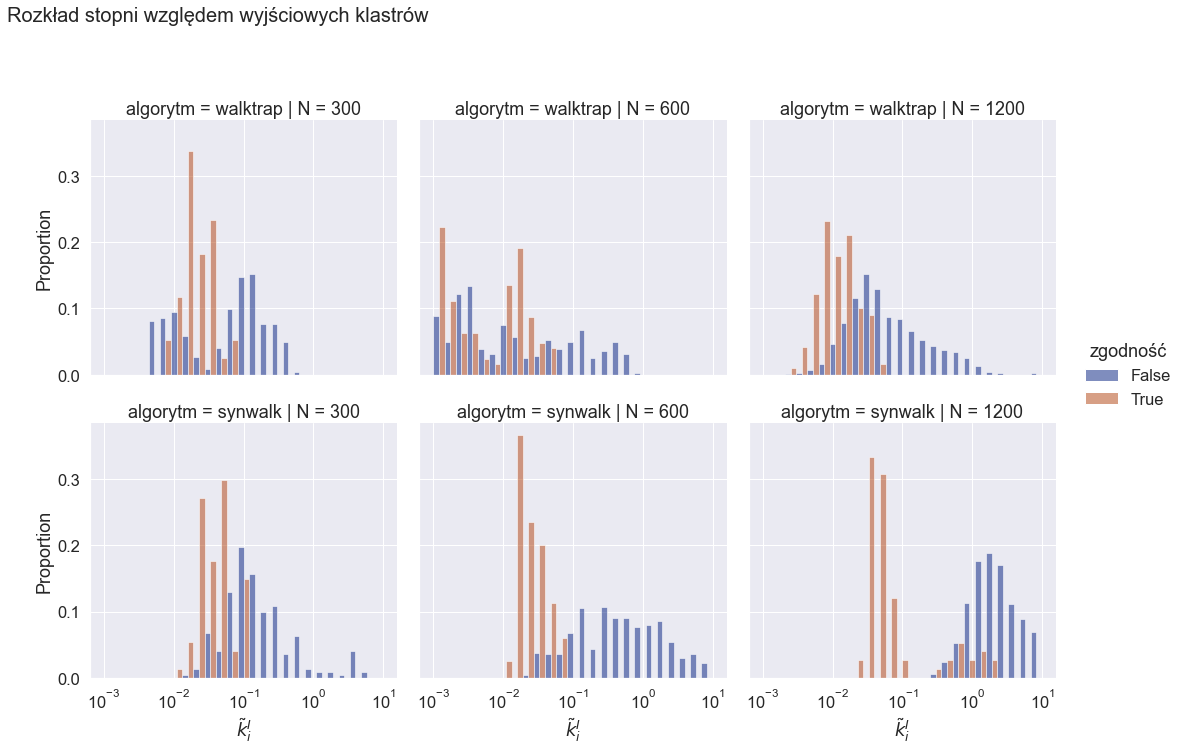

In [617]:
abs_df = dfull.copy()
abs_df = abs_df.replace({'info': 'infomap', 'syn': 'synwalk', 'walk': 'walktrap'})
abs_df = abs_df.rename(columns={'algorithm': 'algorytm', 'class': 'zgodność', 'degree': '$k_i$',
                                'pred_deg': '$\\tilde{k}_i^I$'})
abs_df = abs_df[abs_df['$\\tilde{k}_i^I$'] > 0]
abs_df = abs_df[abs_df['algorytm'] != 'infomap']
g = sns.displot(abs_df, x='$\\tilde{k}_i^I$', multiple='dodge', alpha=.5, binrange=(-3, 1), bins=25,
            hue='zgodność', common_norm=False, col='N', row='algorytm', stat='proportion', log_scale=True, palette='dark')
g.fig.suptitle('Rozkład stopni względem wyjściowych klastrów', y=1.05, ha='left', x=0, fontsize=20)
g.tight_layout()
g.savefig('_pred_norm.pdf')

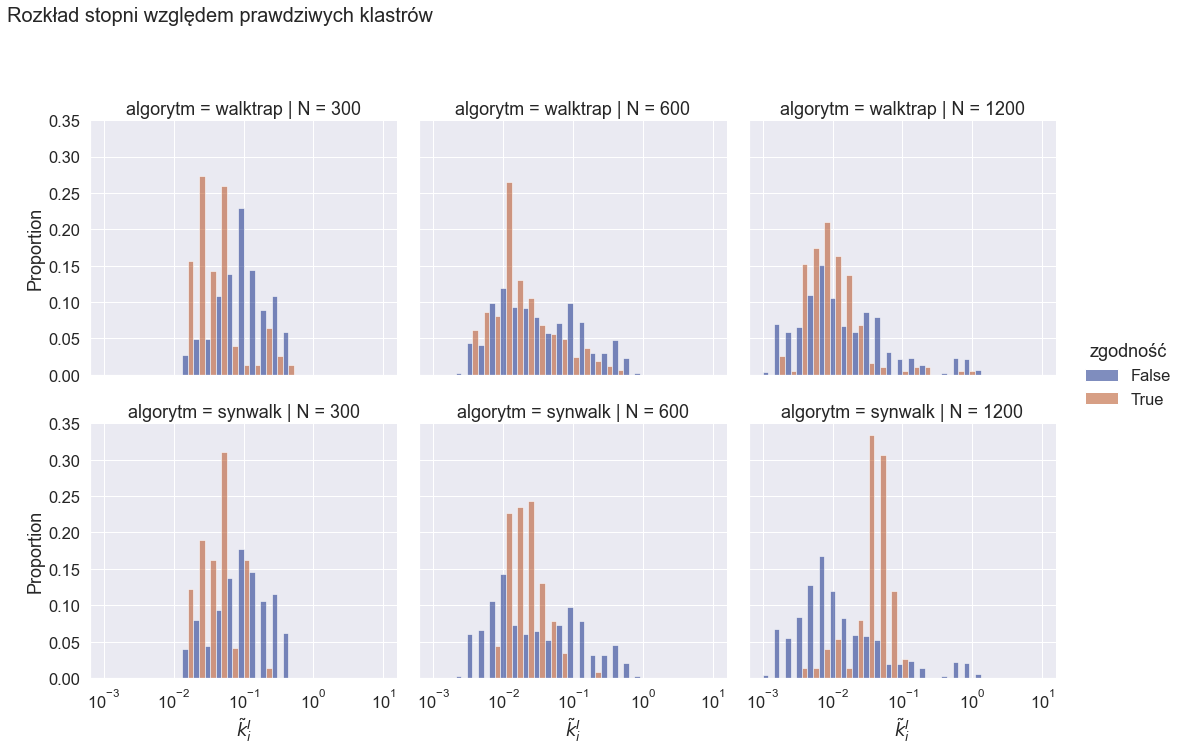

In [614]:
abs_df = dfull.copy()
abs_df = abs_df.replace({'info': 'infomap', 'syn': 'synwalk', 'walk': 'walktrap'})
abs_df = abs_df.rename(columns={'algorithm': 'algorytm', 'class': 'zgodność', 'degree': '$k_i$',
                                'norm_deg': '$\\tilde{k}_i^I$'})
abs_df = abs_df[abs_df['$\\tilde{k}_i^I$'] > 0]
abs_df = abs_df[abs_df['algorytm'] != 'infomap']
g = sns.displot(abs_df, x='$\\tilde{k}_i^I$', bins=25, alpha=.5, multiple='dodge', binrange=(-3, 1),
            hue='zgodność', common_norm=False, col='N', row='algorytm', stat='proportion', log_scale=True, palette='dark')
g.fig.suptitle('Rozkład stopni względem prawdziwych klastrów', y=1.05, ha='left', x=0, fontsize=20)
g.tight_layout()
g.savefig('_true_norm.pdf')

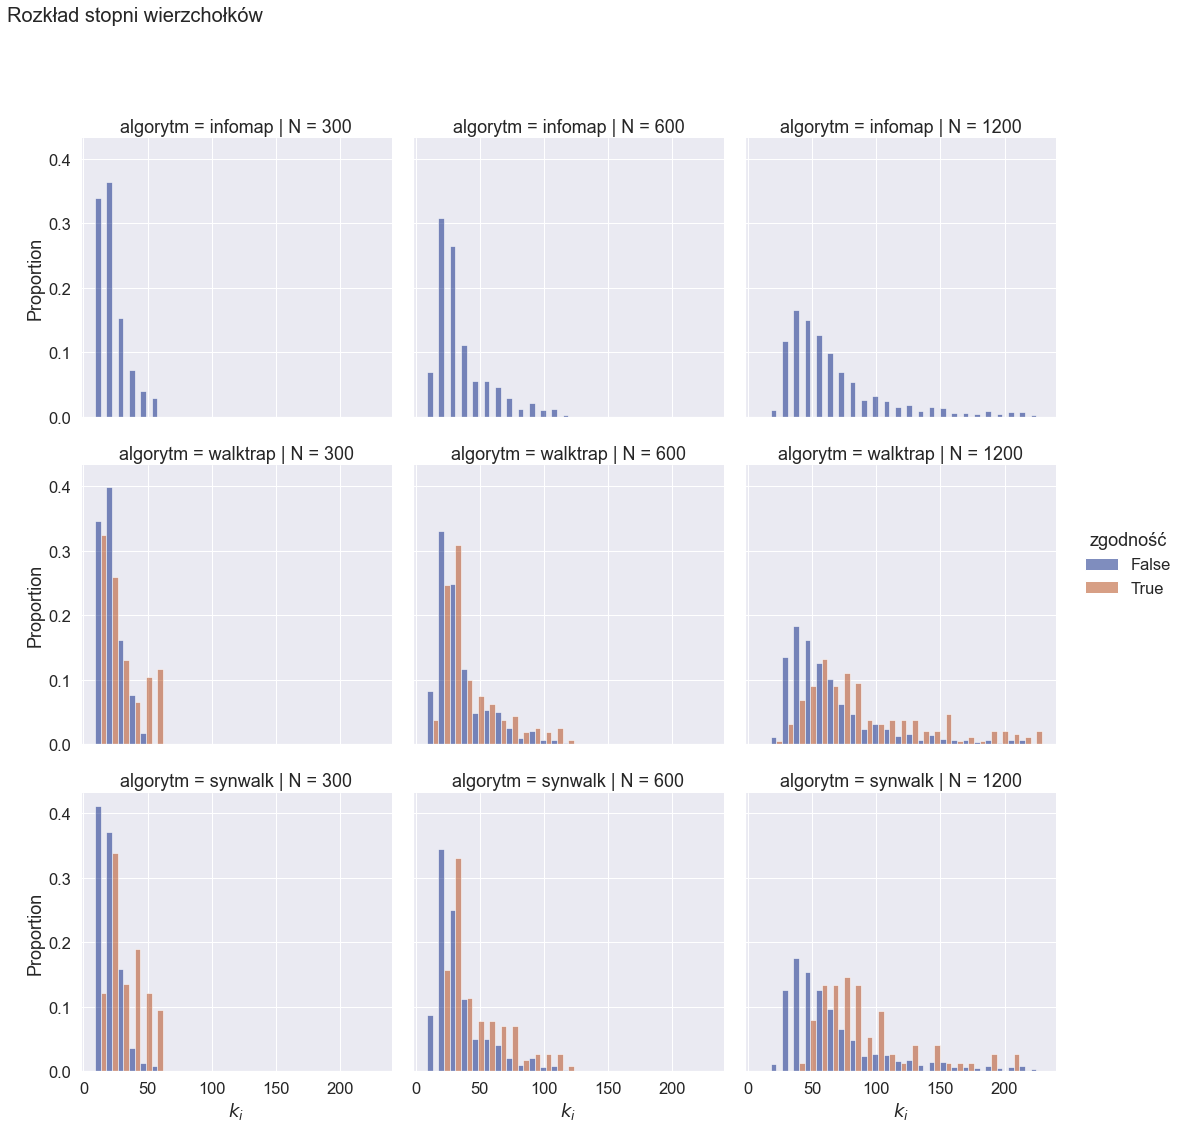

In [605]:
abs_df = dfull.copy()
abs_df = abs_df.replace({'info': 'infomap', 'syn': 'synwalk', 'walk': 'walktrap'})
abs_df = abs_df.rename(columns={'algorithm': 'algorytm', 'class': 'zgodność', 'deg': '$k_i$'})
g = sns.displot(abs_df, x='$k_i$', bins=25, alpha=.5,
            hue='zgodność', common_norm=False, col='N', row='algorytm', stat='proportion', palette='dark',
               multiple='dodge')
g.fig.suptitle('Rozkład stopni wierzchołków', y=1.05, ha='left', x=0, fontsize=20)
g.tight_layout()
g.savefig('_raw_deg.pdf')

In [297]:
from scipy.special import comb

ami_df = pd.DataFrame()

In [504]:
func = {'info': info,
            'walk': trap,
            'syn': syn
            }

def onegen(*args, **kwargs):

    try:
        graph = nx.LFR_benchmark_graph(*args, **kwargs)
        
    except nx.ExceededMaxIterations:
        return {}

    nx.set_edge_attributes(graph, 1, 'weight')
    truth = get_true(graph)
    
    return {al: get_ami(truth, f(graph)) for al, f in func.items()}

def oniter(N, mu, M):
    
    N = int(N)
    print(N, mu)
    res_ami = pd.DataFrame([onegen(N, 2, 1.1, mu, 
                                   average_degree=20, max_degree=int(.095 * N), 
                                   min_community=15, max_community=int(.1 * N))
                            for _ in range(M)])
    res_ami['N'] = N
    res_ami['mu'] = mu
    
    return res_ami

def procall(mus = np.linspace(.4, .6, 11),
            Ns = [600, 1200, 2400],
            M = 10): 
    
    return pd.concat((oniter(N, mu, M) for N, mu in [(N, mu) for mu in mus for N in Ns]), ignore_index=True)

In [505]:
prodf = procall()

600 0.4
1200 0.4
2400 0.4
600 0.42000000000000004
1200 0.42000000000000004
2400 0.42000000000000004
600 0.44
1200 0.44
2400 0.44
600 0.46
1200 0.46
2400 0.46
600 0.48
1200 0.48
2400 0.48
600 0.5
1200 0.5
2400 0.5
600 0.52
1200 0.52
2400 0.52
600 0.54
1200 0.54
2400 0.54
600 0.56
1200 0.56
2400 0.56
600 0.58
1200 0.58
2400 0.58
600 0.6
1200 0.6
2400 0.6


In [506]:
ami_df = pd.concat([ami_df, prodf], ignore_index=True)

In [509]:
ami_df.to_csv('ami_lfr.csv', index=False)

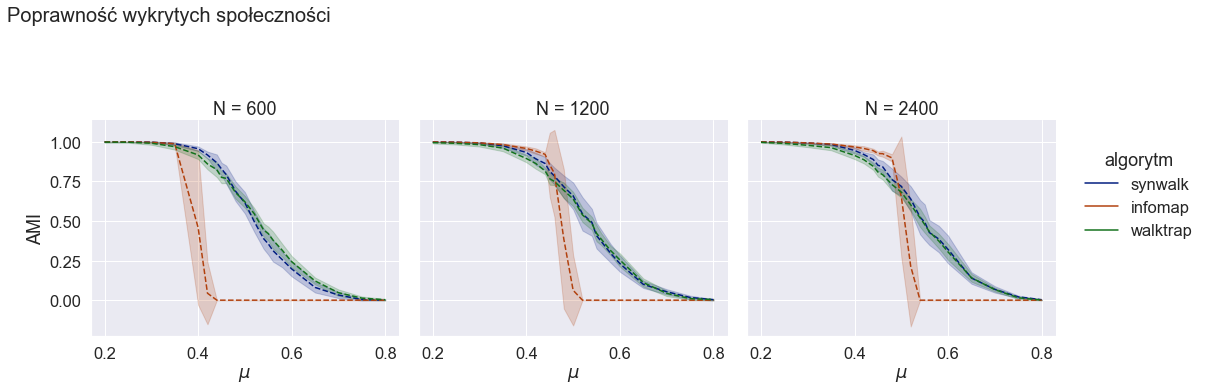

In [607]:
long_df = pd.melt(ami_df.rename(columns={'syn': 'synwalk', 'info': 'infomap', 'walk': 'walktrap'}),
                  id_vars=['N', 'mu'], value_vars=['synwalk', 'infomap', 'walktrap'], 
                  var_name='algorytm', value_name='AMI')
long_df['$\\mu$'] = long_df['mu'].round(2)
long_df['AMI'] = np.minimum(np.maximum(long_df['AMI'], 0), 1)
g = sns.relplot(long_df, x='$\\mu$', y='AMI',  hue='algorytm', col='N', kind='line', linestyle='--', palette='dark',
               errorbar='sd')
g.fig.suptitle('Poprawność wykrytych społeczności', y=1.1, ha='left', x=0, fontsize=20)
g.tight_layout()
g.fig.savefig('ami.pdf')

In [262]:
r_df = pd.DataFrame()
b_df = pd.DataFrame()

def to_leni(membership): 
    
    cmember = np.bincount(membership)
    return np.where(cmember > 0)[0], cmember[cmember > 0]

func = {'info': info,
            'walk': trap,
            'syn': syn
            }

graphs = ['lastfm_asia', 'musae_facebook', 'musae_git'] #, 'wordnet']

for g in graphs[:]:
    
    print(g)
    res_real = pd.DataFrame()
    bob_real = pd.DataFrame()
    
    graph = load_graph(g)
    
    for algo, f in func.items():
        print(algo)
        part_real = pd.DataFrame()
        bobi_real = pd.DataFrame()
        C = f(graph)
        I, part_real['csize'] = to_leni(C)
        binomc = dict(zip(I, comb(part_real['csize'], 2)))
        bobi_real['deg'] = [d / binomc[c] for d, c in zip(graph.degree, C) if binomc[c] > 0]
        part_real['algorithm'] = algo
        bobi_real['algorithm'] = algo
        res_real = pd.concat([res_real, part_real], ignore_index=True)
        bob_real = pd.concat([bob_real, bobi_real], ignore_index=True)
    
    res_real['network'] = g
    bob_real['network'] = g

    r_df = pd.concat([r_df, res_real], ignore_index=True)
    b_df = pd.concat([b_df, bob_real], ignore_index=True)
    
b_df = b_df.explode('deg')

wordnet
inifo
TIME 1166.3411581516266


               algorytm  $|\mathcal{C}|$
sieć                                    
lastfm_asia        info         0.882243
musae_facebook     info         0.925047
musae_git          info         0.833554
wordnet            info         0.966104
lastfm_asia         syn         0.917763
musae_facebook      syn         0.925412
musae_git           syn         0.639694
wordnet             syn         0.965358
lastfm_asia        walk         0.615854
musae_facebook     walk         0.673108
musae_git          walk         0.087977


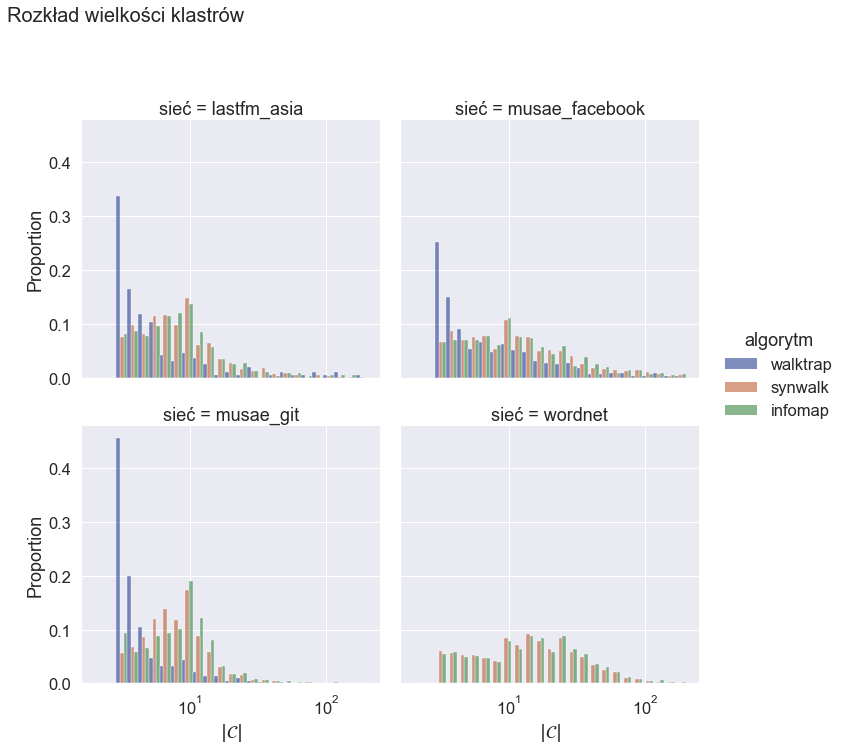

In [616]:
rdf = r_df.copy()
rdf = rdf.rename(columns={'algorithm': 'algorytm', 'csize': '$|\\mathcal{C}|$', 'network': 'sieć', 
                         'syn': 'synwalk', 'info': 'infomap', 'walk': 'walktrap'})
statg = rdf.groupby(['algorytm', 'sieć'])['$|\\mathcal{C}|$'].apply(lambda x: (x >= 3).sum() / len(x)).reset_index(0)
print(statg)
rdf = rdf.replace({'info': 'infomap', 'syn': 'synwalk', 'walk': 'walktrap'})
g = sns.displot(rdf[rdf['$|\\mathcal{C}|$'] >= 3], x='$|\\mathcal{C}|$', 
                hue='algorytm', multiple='dodge', binrange=(.3, 2.3), bins=25,  stat='proportion', edgecolor=None,
                palette='dark', alpha=.5,
                common_norm=False, log_scale=True,  col='sieć', col_wrap=2)
g.fig.suptitle('Rozkład wielkości klastrów', y=1.05, ha='left', x=0, fontsize=20)
g.tight_layout()
g.savefig('real_size.pdf')

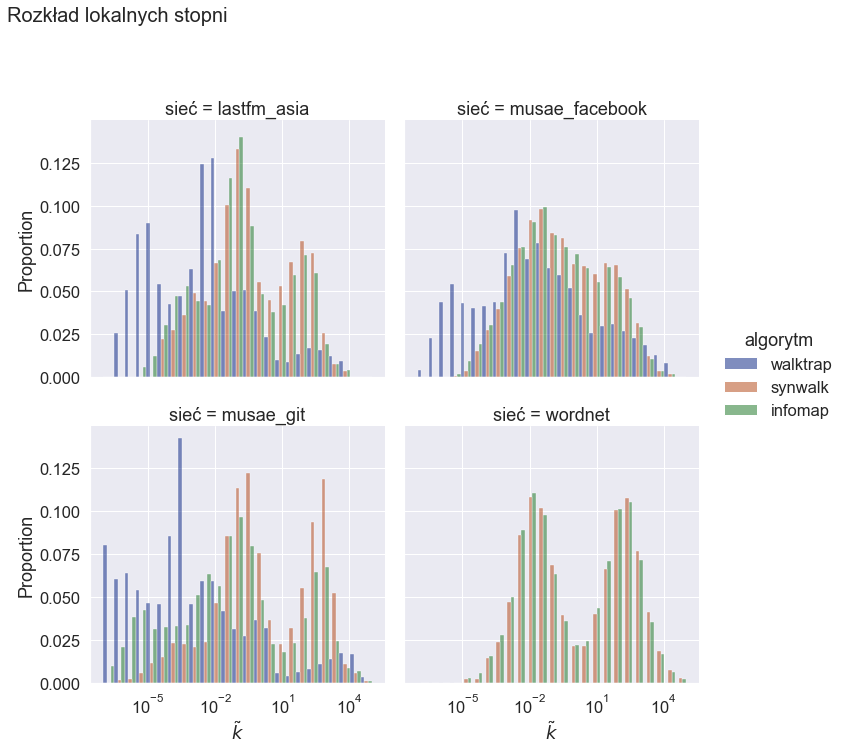

In [615]:
deg = b_df.copy()
deg = deg[deg['deg'] > 0].rename(columns={'algorithm': 'algorytm', 'deg': '$\\tilde{k}$', 'network': 'sieć',
                                         'syn': 'synwalk', 'info': 'infomap', 'walk': 'walktrap'})
deg = deg.replace({'info': 'infomap', 'syn': 'synwalk', 'walk': 'walktrap'})
g = sns.displot(deg, x='$\\tilde{k}$', 
                hue='algorytm', multiple='dodge',  stat='proportion', edgecolor=None,
                palette='dark', alpha=.5, binrange=(-7, 5), bins=25,
                common_norm=False, log_scale=True,  col='sieć', col_wrap=2)

g.fig.suptitle('Rozkład lokalnych stopni', y=1.05, ha='left', x=0, fontsize=20)
g.tight_layout()
g.savefig('degc.pdf')